# Overview

This notebook ingests data from multiple sources and formats and coverts it to a standard HuggingFace dataset format.

All datasets will have "sentence" and "audio" features. Different datasets may contain additional metadata information.

In [1]:
import os
import glob
from pathlib import Path
from typing import Dict, List, Tuple

from tqdm.auto import tqdm
from datasets import Dataset, DatasetDict, Features, Audio, Value
import pandas as pd

# MyST

In [7]:
def find_audio_transcript_pairs(data_dir: str) -> List[Tuple[str, str]]:
    """Find all matching .flac and .trn file pairs"""
    flac_files = glob.glob(os.path.join(data_dir, "**/*.flac"), recursive=True)
    pairs = []
    not_found_counter = 0
    for flac_file in flac_files:
        # Get corresponding .trn file
        trn_file = flac_file.replace('.flac', '.trn')
        
        if os.path.exists(trn_file):
            pairs.append((flac_file, trn_file))
        else:
            not_found_counter += 1

    print(f"Missing {not_found_counter} transcripts. These will not be included in the dataset.")

    return pairs

def read_transcription(trn_file: str) -> str:
    """Read transcription from .trn file"""
    try:
        with open(trn_file, 'r', encoding='utf-8') as f:
            transcript = f.read().strip()
        
        return transcript
    except Exception as e:
        print(f"Error reading {trn_file}: {e}")
        return ""

def extract_metadata(filename: str) -> Dict[str, str]:
    """Extract metadata from filename"""
    basename = os.path.basename(filename)
    parts = basename.replace('.flac', '').replace('.trn', '').split('_')
    
    # Based on your naming: myst_002116_2014-03-04_09-24-51_LS_1.3
    metadata = {
        'speaker_id': parts[1] if len(parts) > 1 else 'unknown',
        'date': parts[2] if len(parts) > 2 else 'unknown',
        'time': parts[3] if len(parts) > 3 else 'unknown',
        'session_type': parts[4] if len(parts) > 4 else 'unknown',
        'version': parts[5] if len(parts) > 5 else 'unknown'
    }
    
    return metadata

def create_dataset_split(data_dir: str, split_name: str) -> Dataset:
    """Create a Hugging Face dataset for one split"""
    print(f"Processing {split_name} split from {data_dir}")
    
    pairs = find_audio_transcript_pairs(data_dir)
    print(f"Found {len(pairs)} audio-transcript pairs")
    
    data = {
        'audio': [],
        'transcription': [],
        'speaker_id': [],
        'date': [],
        'time': [],
        'session_type': [],
        'version': [],
        'split': []
    }
    
    for audio_file, trn_file in pairs:
        # Read transcription
        transcript = read_transcription(trn_file)
        
        if not transcript:  # Skip if no valid transcription
            continue
            
        # Extract metadata
        metadata = extract_metadata(audio_file)
        
        # Add to dataset
        data['audio'].append(audio_file)
        data['transcription'].append(transcript)
        data['speaker_id'].append(metadata['speaker_id'])
        data['date'].append(metadata['date'])
        data['time'].append(metadata['time'])
        data['session_type'].append(metadata['session_type'])
        data['version'].append(metadata['version'])
        data['split'].append(split_name)
    
    # Create dataset
    dataset = Dataset.from_dict(data)
    
    # Cast audio column to Audio feature (16kHz is standard for Whisper)
    dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
    
    return dataset

def convert_myst_to_hf(base_dir: str, output_name: str = "myst-child-speech") -> DatasetDict:
    """Convert full MYST dataset to Hugging Face format"""
    
    # Define paths for each split
    splits = {
        'train': os.path.join(base_dir, 'train'),
        'validation': os.path.join(base_dir, 'development'),  # or 'dev' depending on your structure
        'test': os.path.join(base_dir, 'test')
    }
    
    datasets = {}
    
    for split_name, split_path in splits.items():
        if os.path.exists(split_path):
            print(f"\nProcessing {split_name} split...")
            datasets[split_name] = create_dataset_split(split_path, split_name)
            print(f"{split_name}: {len(datasets[split_name])} samples")
        else:
            print(f"Warning: {split_path} not found, skipping {split_name}")
    
    # Create DatasetDict
    dataset_dict = DatasetDict(datasets)
    
    return dataset_dict

In [ ]:
myst_base_dir = "../data/myst_child_conv_speech/data"

# Convert the dataset
dataset = convert_myst_to_hf(myst_base_dir)

In [12]:
# Print some statistics
print("\n=== Dataset Statistics ===")
for split, data in dataset.items():
    print(f"{split}: {len(data)} samples")
    
    # Show first example
    if len(data) > 0:
        example = data[0]
        print(f"  Example transcription: {example['transcription'][:100]}...")
        print(f"  Audio duration: {len(example['audio']['array']) / example['audio']['sampling_rate']:.2f}s")


=== Dataset Statistics ===
train: 76924 samples
  Example transcription: WELL I NOTICED THAT THERE IS A BATTERY UM THREE WIRES THE SWITCH AND A STEEL NAIL AND I NOTICED THAT...
  Audio duration: 32.35s
validation: 12238 samples
  Example transcription: INSULATION MEANS LIKE THE COPPER WIRE IS INSIDE OF THE GREEN COATING...
  Audio duration: 5.70s
test: 13169 samples
  Example transcription: YOU FILTER IT TO GET SOMETHING THAT IS ALMOST STUCK TO THE WATER TO GET OUT WITH THE...
  Audio duration: 7.03s



=== Audio Length Statistics ===


  0%|          | 0/1000 [00:00<?, ?it/s]


train split:
  Total samples: 1000
  Mean duration: 7.75s
  Min duration: 0.03s
  Max duration: 66.55s
  Duration distribution:
    < 5s: 499 (49.9%)
    5-30s: 478 (47.8%)
    ≥ 30s: 23 (2.3%)


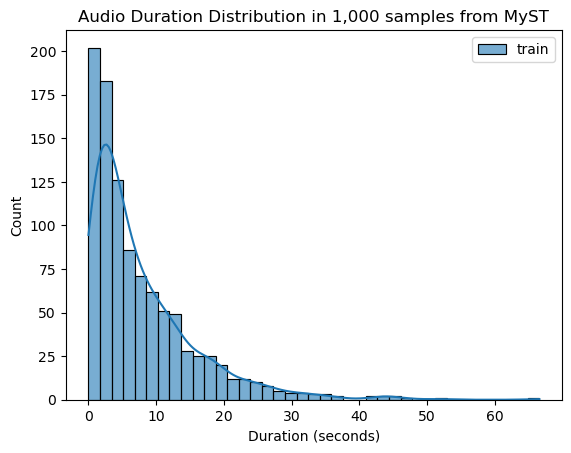

  0%|          | 0/1000 [00:00<?, ?it/s]


validation split:
  Total samples: 1000
  Mean duration: 7.75s
  Min duration: 0.03s
  Max duration: 46.53s
  Duration distribution:
    < 5s: 459 (45.9%)
    5-30s: 522 (52.2%)
    ≥ 30s: 19 (1.9%)


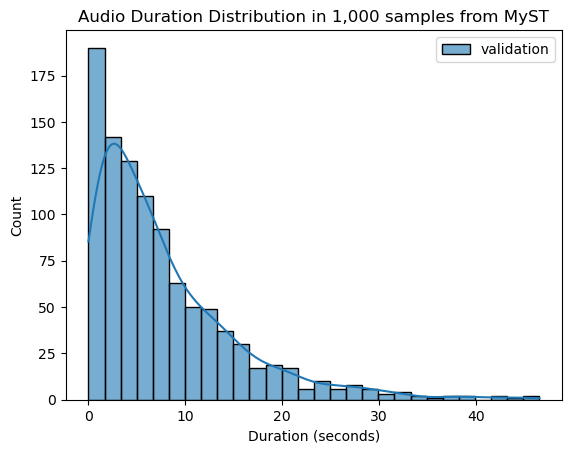

  0%|          | 0/1000 [00:00<?, ?it/s]


test split:
  Total samples: 1000
  Mean duration: 7.29s
  Min duration: 0.03s
  Max duration: 57.95s
  Duration distribution:
    < 5s: 516 (51.6%)
    5-30s: 464 (46.4%)
    ≥ 30s: 20 (2.0%)


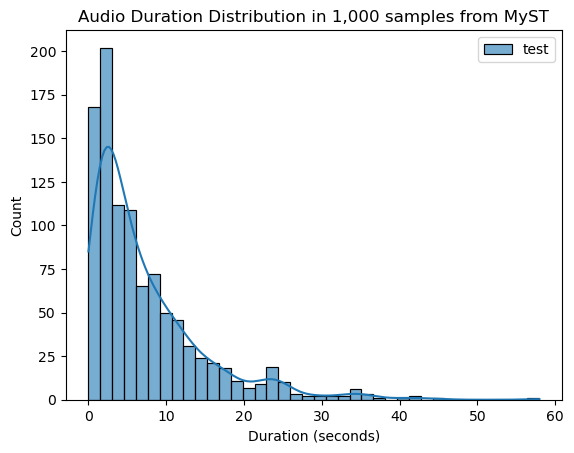

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

print("\n=== Audio Length Statistics ===")
for split, data in dataset.items():
    sample_size = min(1000, len(data))
    data_sample = data.shuffle().select(range(sample_size))
    durations = [len(sample['audio']['array']) / sample['audio']['sampling_rate'] for sample in tqdm(data_sample)]

    print(f"\n{split} split:")
    print(f"  Total samples: {len(durations)}")
    print(f"  Mean duration: {sum(durations)/len(durations):.2f}s")
    print(f"  Min duration: {min(durations):.2f}s")
    print(f"  Max duration: {max(durations):.2f}s")
    
    # Count by duration ranges
    short = sum(1 for d in durations if d < 5)
    medium = sum(1 for d in durations if 5 <= d < 30)
    long = sum(1 for d in durations if d >= 30)
    
    print(f"  Duration distribution:")
    print(f"    < 5s: {short} ({short/len(durations)*100:.1f}%)")
    print(f"    5-30s: {medium} ({medium/len(durations)*100:.1f}%)")
    print(f"    ≥ 30s: {long} ({long/len(durations)*100:.1f}%)")
    sns.histplot(durations, alpha=0.6, label=split, kde=True)

    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')
    plt.title('Audio Duration Distribution in 1,000 samples from MyST')
    plt.legend()
    plt.show()

In [9]:
# Save locally
myst_output_path = "../data/myst_dataset.ds"
dataset.save_to_disk(myst_output_path)
print(f"\nDataset saved to {myst_output_path}")

Saving the dataset (0/25 shards):   0%|          | 0/76924 [00:00<?, ? examples/s]

Saving the dataset (0/4 shards):   0%|          | 0/12238 [00:00<?, ? examples/s]

Saving the dataset (0/3 shards):   0%|          | 0/13169 [00:00<?, ? examples/s]


Dataset saved to ../data/myst_dataset.ds


## CSLU Kids

In [5]:
# Path to your decompressed directory
cslu_dir_path = "../data/cslu_kids"  # Adjust this to your decompressed directory path

def read_transcript(transcript_path: str) -> str:
    """Read transcript content from a file path."""
    try:
        with open(transcript_path, 'r', encoding='utf-8') as f:
            content = f.read().strip()
            return content
    except Exception as e:
        print(f"Could not read transcript {transcript_path}: {e}")
        return ""

def extract_and_match_files(dir_path: str) -> Dataset:
    """
    Find matching audio and transcript files in a directory structure.
    
    Args:
        dir_path: Path to the decompressed directory
        
    Returns:
        Hugging Face Dataset with 'audio' and 'sentence' features
    """
    audio_transcript_pairs = []
    
    # Walk through the directory structure
    audio_files = {}
    transcript_files = {}
    
    for root, dirs, files in os.walk(dir_path):
        path_parts = Path(root).parts
        
        for file in files:
            file_path = os.path.join(root, file)
            file_id = Path(file).stem
            
            # Check if it's an audio file in speech directory
            if 'speech' in path_parts and file.endswith('.wav'):
                audio_files[file_id] = file_path
            
            # Check if it's a transcript file in trans directory
            elif 'trans' in path_parts and file.endswith('.txt'):
                transcript_files[file_id] = file_path
    
    # Find matching pairs
    common_ids = set(audio_files.keys()) & set(transcript_files.keys())
    print(f"Found {len(common_ids)} matching audio-transcript pairs")
    
    # Build lists of matched audio paths and sentences
    audio_paths = []
    sentences = []
    
    for file_id in common_ids:
        audio_path = audio_files[file_id]
        transcript_path = transcript_files[file_id]
        
        # Read the transcript
        sentence = read_transcript(transcript_path)
        
        # Only add if we successfully read the transcript
        if sentence:
            audio_paths.append(audio_path)
            sentences.append(sentence)
    
    print(f"Successfully processed {len(audio_paths)} pairs")
    print("Building dataset...")
    
    # Create dataset with correct feature name 'sentence' instead of 'sentences'
    ds = Dataset.from_dict({
        "audio": audio_paths,
        "sentence": sentences  # Changed from 'sentences' to 'sentence'
    })
    
    print("Casting dataset column...")
    ds = ds.cast_column("audio", Audio())
    
    return ds

# Create the dataset
cslu_kids = extract_and_match_files(cslu_dir_path)

# Print dataset info
print(f"\nDataset created successfully!")
print(f"Number of samples: {len(cslu_kids)}")
print(f"Features: {cslu_kids.features}")

# Show first sample info
if len(cslu_kids) > 0:
    first_sample = cslu_kids[0]
    print(f"\nFirst sample:")
    print(f"Audio path: {first_sample['audio']['path']}")
    print(f"Sentence: {first_sample['sentence'][:100]}...")  # First 100 chars

Found 1101 matching audio-transcript pairs
Successfully processed 1101 pairs
Building dataset...
Casting dataset column...

Dataset created successfully!
Number of samples: 1101
Features: {'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None), 'sentence': Value(dtype='string', id=None)}

First sample:
Audio path: ../data/cslu_kids/speech/spontaneous/02/0/ksd14/ksd14xx0.wav
Sentence: <bn> a b c d e f g <br> h i j k<ln> l m n o p<ln> <br> q r s t u v w x y and z <bn> <pau> my<bn> fam...


In [6]:
# Save dataset
output_path = "../data/cslu_kids.ds"
cslu_kids.save_to_disk(output_path)
print(f"\nDataset saved to: {output_path}")

Saving the dataset (0/8 shards):   0%|          | 0/1101 [00:00<?, ? examples/s]


Dataset saved to: ../data/cslu_kids.ds
